In [2]:
# 라이브러리 설치
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    # !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap
    !pip install xgboost

In [3]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumBarunGothic')
plt.rc('axes', unicode_minus=False)
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import shap

# from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, TargetEncoder
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv('/content/train.csv')

In [5]:
test = pd.read_csv('/content/test.csv')

## 모델링
* 평가지표 : Accuracy, Recall, F1_score, AUC
* 정확도만 가지고 평가하기에는 데이터 불균형으로 인해 우리 예측하고자 하는 타겟(이탈자)을 제대로 예측하지 못하는 경우가 생긴다.
* 때문에 정확도와 더불어 Recall, F1_score, AUC를 함께 고려해 주어야 한다

In [6]:
# 모델 평가지표 출력 함수
def evaluate(model, X, y):
    pred = model.predict(X)
    accuracy = accuracy_score(y, pred)
    recall = recall_score(y, pred)
    auc = roc_auc_score(y, pred)
    f1 = f1_score(y, pred)
    
    print("Accuracy:", accuracy)
    print("F1_score: ", f1)
    print("Recall: ", recall)
    print("AUC: ", auc)
    print("-----------------------------\n")

In [7]:
# 학습/검증셋으로 나누기
train,val = train_test_split(train, train_size=0.8)

# 타겟/독립변수로 나누기
target = "churn"
y_train = train[target]
X_train = train.drop(columns=target)

y_val = val[target]
X_val = val.drop(columns=target)

y_test = test[target]
X_test = test.drop(columns=target)

In [8]:
# 인코딩, 스케일링 진행
preprocessing_pipe = Pipeline(
    [("encoder",OneHotEncoder(use_cat_names=True)),
    ("scaler",StandardScaler())])
preprocessing_pipe.fit(X_train)

X_train_pre = preprocessing_pipe.transform(X_train)
X_val_pre = preprocessing_pipe.transform(X_val)

### Baseline Model
* 타겟 변수의 최빈값으로 예측하는 모델

In [9]:
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, auc, confusion_matrix, recall_score

major = y_train.mode()[0] # 최빈값 추출
pred_train = [major] * len(y_train) # 최빈값으로 트레인 데이터셋 예측

pred_val = [major] * len(y_val) # 최빈값으로 검정 데이터셋 예측

print("--- train --------")
print("Accuracy:",accuracy_score(y_train, pred_train)) # 정확도
print("F1_score:",f1_score(y_train, pred_train)) # F1_score
print("Recall:",recall_score(y_train, pred_train)) # F1_score
print("AUC",roc_auc_score(y_train, pred_train)) # ROC-curve의 면적(AUC)

print("--- validation --------")
print("Accuracy:",accuracy_score(y_val, pred_val))
print("F1_score:",f1_score(y_val, pred_val))
print("Recall:",recall_score(y_val, pred_val)) # F1_score
print("AUC",roc_auc_score(y_val, pred_val))

--- train --------
Accuracy: 0.7373107747105966
F1_score: 0.0
Recall: 0.0
AUC 0.5
--- validation --------
Accuracy: 0.7259786476868327
F1_score: 0.0
Recall: 0.0
AUC 0.5


* 정확도는 어느정도 높지만, 재현율, F1_score, AUC와 같은 다른 모델 평가 지표에서는 형편없는 성능을 보인다
* 이는 타겟 변수의 데이터 불균형으로부터 비롯된 것으로 보인다
* 해당 부분을 보완하여 모델을 학습시킬 필요가 있다.

### UpSampling

In [10]:
from imblearn.over_sampling import SMOTE

X_train_upsample, y_train_upsample = SMOTE(random_state=42).fit_resample(X_train_pre, y_train)
pd.DataFrame(y_train_upsample).value_counts(normalize=True)

churn
0        0.5
1        0.5
dtype: float64

* SMOTE방식을 사용하여 데이터 균형을 맞춰주었다

### Logistic Regression Model

In [11]:
logistic1 = LogisticRegression().fit(X_train_upsample, y_train_upsample)

print("[ training ] ")
evaluate(logistic1, X_train_upsample, y_train_upsample)
print("[ validataion ]")
evaluate(logistic1, X_val_pre, y_val)

[ training ] 
Accuracy: 0.7749094202898551
F1_score:  0.7826847398338435
Recall:  0.8106884057971014
AUC:  0.774909420289855
-----------------------------

[ validataion ]
Accuracy: 0.7473309608540926
F1_score:  0.6340206185567011
Recall:  0.7987012987012987
AUC:  0.7633212375859436
-----------------------------



* 따로 하이퍼파라미터 튜닝없이 기본적인 로지스틱회귀모델을 적용했다
* 모델 성능이 나름 괜찮은 것 같다

### RandomForest Classifier Model

In [12]:
from scipy.stats import randint, uniform

rf_pipe = Pipeline([("rf", RandomForestClassifier(random_state=2))])

param_distribs = {
        'rf__n_estimators': randint(low=50, high=500),
        'rf__max_depth': randint(1,30),
        'rf__max_features': uniform(0,1),
    }

clf1 = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_distribs,
    n_iter=30,
    cv=3,
    scoring="f1",
    verbose=1,
    n_jobs=-1,
    random_state=2)

clf1.fit(X_train_upsample, y_train_upsample)
rf_pipe = clf1.best_estimator_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [13]:
print("[ training ] ")
evaluate(rf_pipe, X_train_upsample, y_train_upsample)
print("[ validataion ]")
evaluate(rf_pipe, X_val_pre, y_val)

[ training ] 
Accuracy: 0.9648248792270532
F1_score:  0.965990366369873
Recall:  0.9990942028985508
AUC:  0.9648248792270532
-----------------------------

[ validataion ]
Accuracy: 0.7749110320284698
F1_score:  0.6160849772382397
Recall:  0.6590909090909091
AUC:  0.7388591800356507
-----------------------------



* 랜덤포레스트 모델은 하이퍼파라미터 튜닝 후 최적의 파라미터를 적용했지만, 훈련데이터셋에 상당히 과적합된 모델성능을 보여준다

### Xgboost Model

In [14]:
xgb_pipe = Pipeline([("xgb",XGBClassifier(random_state=2, n_jobs=-1))])

param_distribs = {'xgb__n_estimators': randint(low=50, high=500), 
                'xgb__learning_rate': [0.05, 0.1, 0.2],
                'xgb__max_depth' : randint(1,30),
              }


clf2 = RandomizedSearchCV(
    xgb_pipe,
    param_distributions=param_distribs,
    n_iter=30,
    cv=3,
    scoring="f1",
    verbose=1,
    n_jobs=-1,
    random_state=2)

clf2.fit(X_train_upsample, y_train_upsample)
xgb_pipe = clf2.best_estimator_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


In [15]:
print("[ training ] ")
evaluate(xgb_pipe, X_train_upsample, y_train_upsample)
print("[ validataion ]")
evaluate(xgb_pipe, X_val_pre, y_val)

[ training ] 
Accuracy: 0.9984903381642513
F1_score:  0.9984907938424388
Recall:  0.998792270531401
AUC:  0.9984903381642511
-----------------------------

[ validataion ]
Accuracy: 0.7633451957295374
F1_score:  0.5895061728395062
Recall:  0.6201298701298701
AUC:  0.7187659154570919
-----------------------------



* 여전히 모델의 과적합이 심하다
* 이전 모델에서보다 일반화 성능이 더 떨어진 모습이다

### LightGBM

In [16]:
from lightgbm import LGBMClassifier

lgbm_pipe = Pipeline([("lgbm", LGBMClassifier(random_state=2, n_jobs=-1, objective="binary"))]    
)

param_distributions = {'lgbm__n_estimators': randint(low=50, high=500), 
              'lgbm__learning_rate': [None, 0.05, 0.1, 0.2],
              'lgbm__max_depth' : randint(1,15),
              'lgbm__num_leaves': randint(1,50),
              'lgbm__max_features': uniform(0,1),
              }


clf3 = RandomizedSearchCV(
    lgbm_pipe,
    param_distributions=param_distributions,
    n_iter=40,
    cv=3,
    scoring="f1",
    verbose=1,
    n_jobs=-1,
    random_state=2)

clf3.fit(X_train_upsample, y_train_upsample)
lgbm_pipe = clf3.best_estimator_

Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [17]:
print("[ training ]")
evaluate(lgbm_pipe, X_train_upsample, y_train_upsample)
print("[ validataion ]")
evaluate(lgbm_pipe, X_val_pre, y_val)

[ training ]
Accuracy: 0.851147342995169
F1_score:  0.8552979160551805
Recall:  0.8798309178743962
AUC:  0.851147342995169
-----------------------------

[ validataion ]
Accuracy: 0.7651245551601423
F1_score:  0.6239316239316239
Recall:  0.711038961038961
AUC:  0.7482890883626179
-----------------------------



* LGBM 역시 과적합이 존재하긴 하지만 검정 테스트셋에서도 그렇게 나쁜 성능을 보이진 않고 있다
* 무엇보다 모델이 빨리 돌아가서 시간적인 측면에서 장점이 크다
* LGBM을 최종모델로 선정해보려 한다


In [18]:
X_test_pre = preprocessing_pipe.transform(X_test)

print("[ test ]")
evaluate(lgbm_pipe, X_test_pre, y_test)

[ test ]
Accuracy: 0.7758007117437722
F1_score:  0.6236559139784946
Recall:  0.7073170731707317
AUC:  0.7537550616818909
-----------------------------



* test set에서도 검증 데이터셋에서 확인했던 모델 성능과 비슷한 결과를 내주었다
* 어느정도 과적합이 있긴했지만 일반화 성능도 나쁘지는 않은 것 같다
* BaselineModel과 비교했을 때, F1_score, Recall과 같은 지표에서 성능이 굉장히 개선되었다.

## 분석결과 시각화

### 변수 중요도


In [19]:
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    lgbm_pipe.named_steps["lgbm"],
    scoring="f1",
    n_iter=5,
    random_state=2
)

permuter.fit(X_val_pre, y_val)

PermutationImportance(estimator=LGBMClassifier(learning_rate=0.05, max_depth=5,
                                               max_features=0.8508505040045017,
                                               n_estimators=111, num_leaves=7,
                                               objective='binary',
                                               random_state=2),
                      random_state=2, scoring='f1')

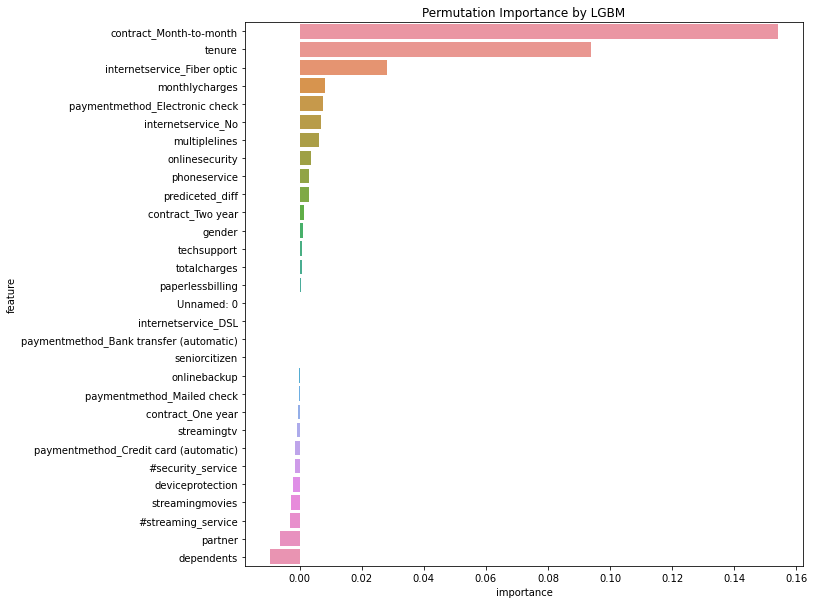

In [20]:
import eli5
enc = preprocessing_pipe.named_steps["encoder"]
feature_names = enc.get_feature_names()


perm_imp_df = pd.DataFrame()
perm_imp_df["feature"] = feature_names
perm_imp_df["importance"] = permuter.feature_importances_
perm_imp_df = perm_imp_df.sort_values(["importance"],ascending=False)

plt.figure(figsize=(10,10))
sns.barplot(x="importance", y="feature", data=perm_imp_df)
plt.title("Permutation Importance by LGBM");

* Feature Engineering으로 만들어낸 변수들이 어느정도 상위에 랭크하고 있다
* 상위랭크 : contract_month_to_month, tenure, internetservice_Fiber optic, contract_two_year, predicted_diff
* 하위랭크 : streamingmovies, seniorcitizenn, contract_one_year, deviceprotection, techsupport, onlinebackup

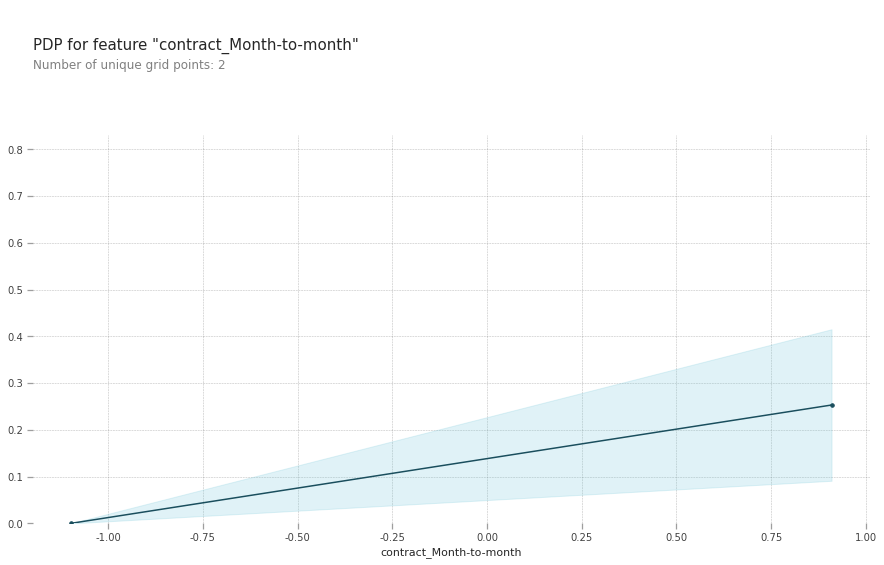

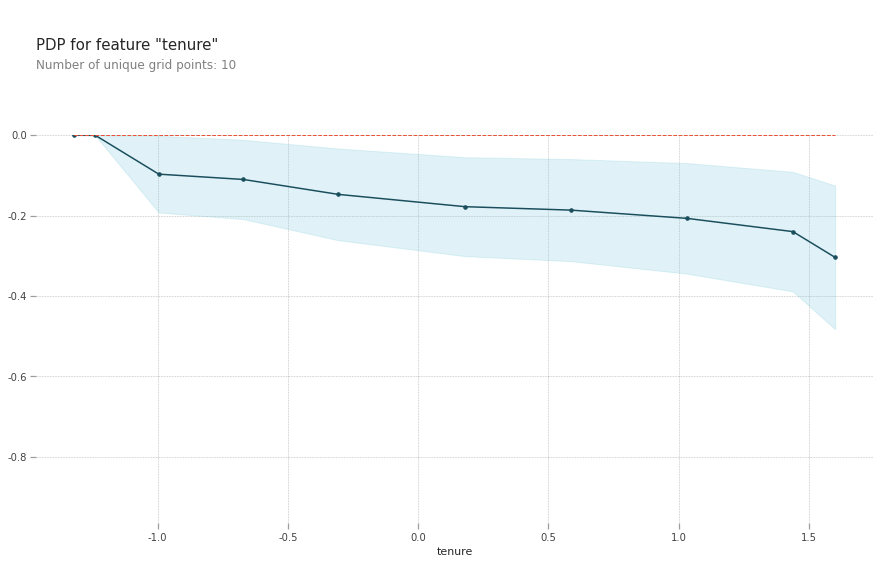

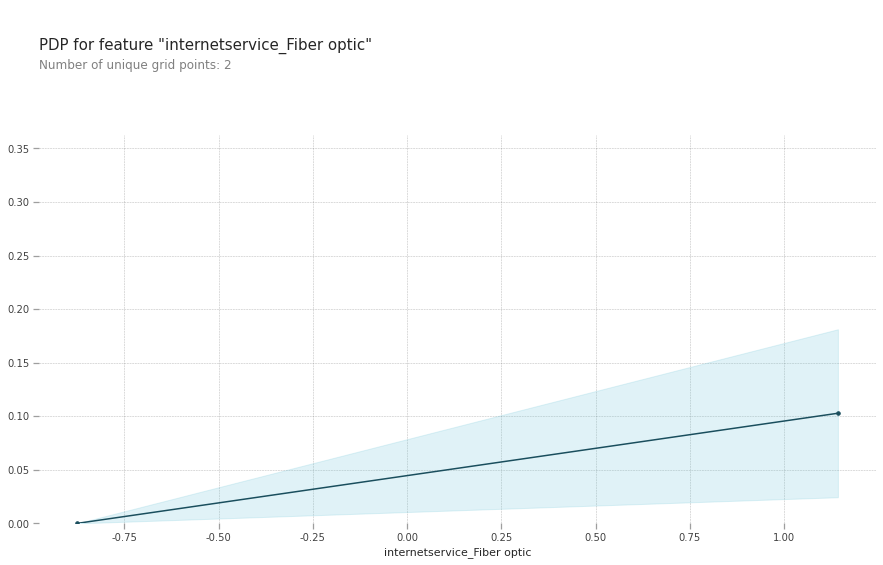

In [21]:
# 상위랭크(top3)에 위치한 변수들의 영향도를 살펴보자
features = perm_imp_df["feature"].iloc[:3].tolist()
X_test_df = pd.DataFrame(X_test_pre, columns=feature_names)

for feature in features:
    isolated = pdp_isolate(
        model = lgbm_pipe,
        dataset=X_test_df,
        model_features = feature_names,
        feature=feature
        # feature = feature,
        # grid_type = "percentile",
        # num_grid_points = 10
    )
    sns.set(font_scale=2)
    pdp_plot(isolated, feature_name=feature);

* EDA 분석에서 분석했던 결과와 거의 동일한 영향을 미치고 있다

## 모델의 한계
* 데이터의 크기가 작아서 과적합될 우려가 있다
* 과적합 문제를 완전히 해결하진 못했다
* 데이터 수급이 굉장히 간단하게 되어 있고, 변수 자체도 정제되어 들어와있는데, 이러한 데이터를 만나기는 쉽지 않다

## 모델의 유용성
* 해당 모델에서 살펴봤던 타겟변수와 피쳐들의 관계에 대한 분석은 추후 고객 유지 방법을 모색할 때 유용한 지표로 사용될 수 있다